# Solemene N°2 Jaime Garcia

### Objetivo específico: Realizar una comparativa de las características de agrupamiento que se desarrollan en el algoritmo K-means y agglomerativeClustering.

#### Objetivo: Usando el conjunto de datos dado, desarrollará un modelo predictivo para predecir qué pacientes diabéticos hospitalizados serán readmitidos por su condición en una fecha posterior y utilizará un enfoque de K-Means para proponer un conjunto no trivial de grupos de pacientes.

## Importacion de Librerias necesarias para el algoritmo

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist,pdist
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

### Llamado al dataframe

In [22]:
data = pd.read_csv('ejemplo.csv',)

### Visualizanción incial del DataFrame

In [23]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [24]:
 data.shape

(998, 50)

In [25]:
for feature in data.columns:
    null = [x for x in data[feature] if x == '?']
    print('Total de valores nulos de', feature, '=', len(null))

Total de valores nulos de encounter_id = 0
Total de valores nulos de patient_nbr = 0
Total de valores nulos de race = 31
Total de valores nulos de gender = 0
Total de valores nulos de age = 0
Total de valores nulos de weight = 998
Total de valores nulos de admission_type_id = 0
Total de valores nulos de discharge_disposition_id = 0
Total de valores nulos de admission_source_id = 0
Total de valores nulos de time_in_hospital = 0
Total de valores nulos de payer_code = 998
Total de valores nulos de medical_specialty = 322
Total de valores nulos de num_lab_procedures = 0
Total de valores nulos de num_procedures = 0
Total de valores nulos de num_medications = 0
Total de valores nulos de number_outpatient = 0
Total de valores nulos de number_emergency = 0
Total de valores nulos de number_inpatient = 0
Total de valores nulos de diag_1 = 1
Total de valores nulos de diag_2 = 9
Total de valores nulos de diag_3 = 34
Total de valores nulos de number_diagnoses = 0
Total de valores nulos de max_glu_s

In [26]:
targets = data.readmitted

In [27]:
data = data[['num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses','gender']]

In [28]:
data.dtypes

num_lab_procedures     int64
num_procedures         int64
num_medications        int64
number_outpatient      int64
number_emergency       int64
number_inpatient       int64
number_diagnoses       int64
gender                object
dtype: object

### Remplazando las variables categoricas como genero  y readmicion por variables numericas 

In [29]:
data['gender'] = data['gender'].replace('Female',0).replace('Male',1)

In [30]:
targets = targets.replace('NO',0).replace('>30',1).replace('<30',2)

In [31]:
 # Vemos cuantas personas hay de cada categoria (raza de cada persona)
targets.unique()

array([0, 1, 2], dtype=int64)

In [32]:
data = data[data['gender'] !=  'Unknown/Invalid']


In [33]:
 # Vemos cuantas personas hay de cada categoria (raza de cada persona)
data.groupby('gender').size()

gender
0    523
1    475
dtype: int64

### Visualizacion de distribución de las categorías

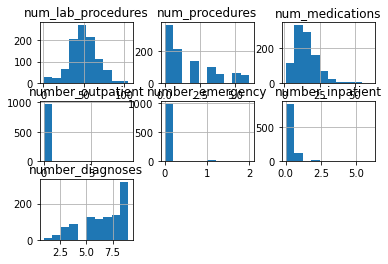

In [34]:
data.drop(['gender'],1).hist()
plt.show()

In [36]:
kmeans = KMeans(n_clusters=5).fit(data)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 4.76826347e+01  1.49101796e+00  1.34191617e+01  3.59281437e-02
   2.39520958e-02  2.39520958e-01  6.76946108e+00  4.94011976e-01]
 [ 1.31166667e+01  1.83333333e+00  1.23333333e+01  1.33333333e-01
   1.66666667e-02  2.00000000e-01  5.80000000e+00  4.66666667e-01]
 [ 6.12085106e+01  1.27659574e+00  1.41617021e+01  2.55319149e-02
   2.97872340e-02  1.91489362e-01  6.82127660e+00  4.63829787e-01]
 [ 7.56046512e+01  2.58914729e+00  2.38372093e+01  1.55038760e-01
  -6.93889390e-18  1.47286822e-01  7.72093023e+00  4.65116279e-01]
 [ 3.44125000e+01  1.69583333e+00  1.23333333e+01  2.50000000e-02
  -1.04083409e-17  2.29166667e-01  6.18333333e+00  4.70833333e-01]]


### Obtener el clúster a través del Metodo del Codo

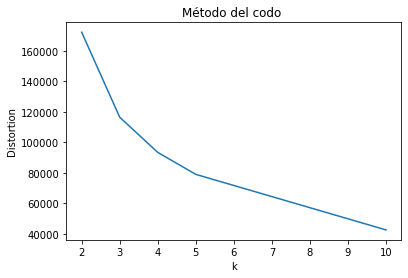

In [37]:
distortions = []
Ks = [2, 3, 4, 5, 10]
for k in Ks:
    kmeans = KMeans(n_clusters = k)
    model = kmeans.fit(data)
    centers = model.cluster_centers_
    distortions.append(model.inertia_)

plt.plot(Ks, distortions)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Método del codo ')
plt.show()


### Obtener el clúster a través del Metodo Silueta

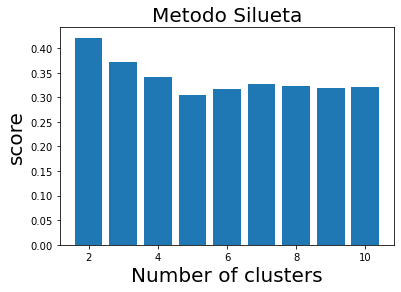

In [40]:
range_n_clusters = [2,3,4,5,6,7,8,9,10]
silhouettes  = []
for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data)
    

    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouettes.append(silhouette_avg)
    

plt.bar(range_n_clusters, silhouettes)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('score', fontsize = 20)
plt.title('Metodo Silueta', fontsize = 20)
plt.show()

In [42]:
algoritmo = KMeans(n_clusters = 3, init = 'k-means++', 
                   max_iter = 300, n_init = 10)
algoritmo.fit(data)

KMeans(n_clusters=3)

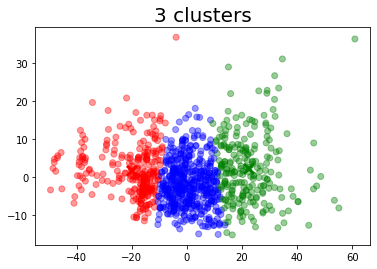

In [47]:
pca_model = PCA(n_components = 2)
pca_model.fit(data)
pca = pca_model.transform(data) 

centroides, etiquetas = algoritmo.cluster_centers_, algoritmo.labels_
centroides_pca = pca_model.transform(centroides)
colores = ['blue', 'red', 'green']
colores_cluster = [colores[etiquetas[i]] for i in range(len(pca))]
plt.scatter(pca[:, 0], pca[:, 1], c = colores_cluster, 
            marker = 'o',alpha = 0.4)

plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1],
            marker = 'x', s = 100, linewidths = 3, c = colores)

xvector = pca_model.components_[0] * max(pca[:,0])
yvector = pca_model.components_[1] * max(pca[:,1])
columnas = data.columns
plt.title("3 clusters", fontsize="20")
plt.show()

### Análisis del gráfico
Es posible ver los puntos de datos en forma de tres grupos. Los puntos de datos en la parte inferior derecha pertenecen a los pacientes con mas probabilidad de reingresar al recinto hospitalitario. Se puede apreciar bastantes outliers que contiene el dataset que pueden alterar el resultado de este, en donde por motivos de tiempos no se realizo una limpieza exhaustiva para quitar estos datos anomalos.

In [46]:
print(classification_report(targets,algoritmo.labels_))


              precision    recall  f1-score   support

           0       0.45      0.46      0.45       487
           1       0.36      0.24      0.29       417
           2       0.10      0.26      0.15        94

    accuracy                           0.35       998
   macro avg       0.31      0.32      0.30       998
weighted avg       0.38      0.35      0.36       998



### Conclusiones en el otro Notebook 